In [1]:
import os
import cv2
import random
import tensorflow
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

2024-08-08 08:57:46.852042: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dem_size = 128
def get_model():
    inputs = layers.Input(shape=(dem_size, dem_size, 3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, (3, 3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    previous_block_activation = x  # Set aside residual

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(3, 3, padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


# Build model
model = get_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]  

 Total params: 3,085,123 (11.77 MB)

 Trainable params: 3,081,347 (11.75 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [15]:
# plot_model(model, show_shapes=True)

In [2]:
root = "./data/"
input_dir = os.path.join(root, "training_img_rgb/")
target_dir = os.path.join(root, "target_img_rgb/")

all_img_names = [f for f in os.listdir(target_dir) if f.endswith(".jpg")]

batch_size = 32

input_img_paths = [f for f in os.listdir(input_dir)]
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in all_img_names])

target_img_paths = [f for f in os.listdir(target_dir)]
target_img_paths = sorted([os.path.join(target_dir, f) for f in all_img_names])

assert len(input_img_paths) == len(target_img_paths)
print("Number of samples:", len(input_img_paths), len(target_img_paths))

Number of samples: 10553 10553


(<Axes: >, <matplotlib.image.AxesImage at 0x15d81d810>)

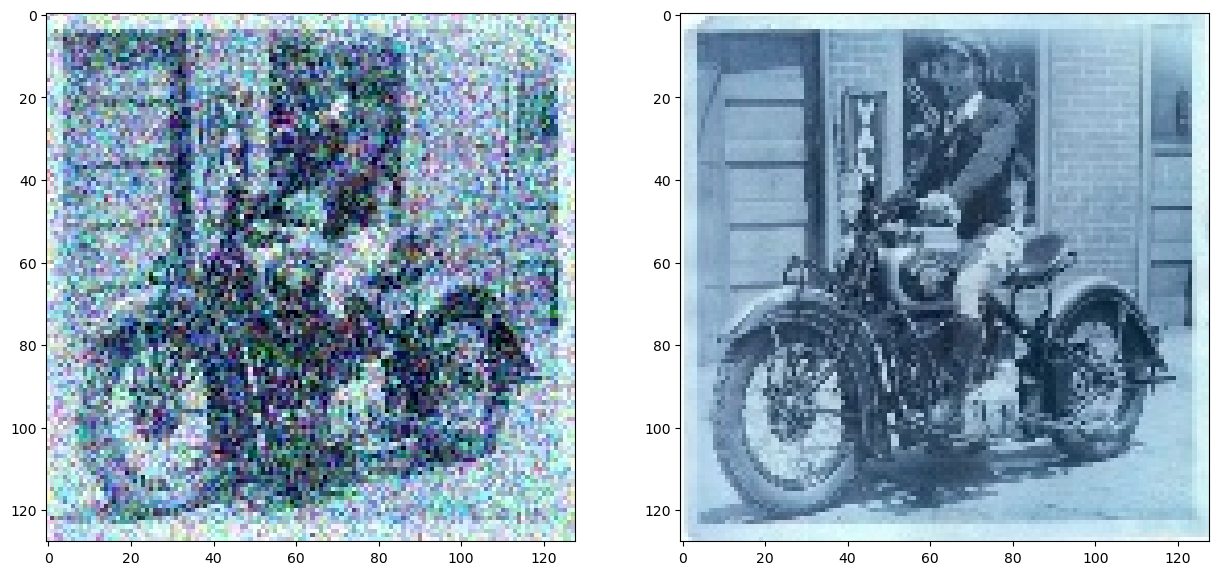

In [11]:
# from tensorflow.keras.preprocessing.image import load_img
# ii = 2
ii = random.randint(0, 10000)

# img_np = cv2.imread(target_img_paths[ii], cv2.IMREAD_GRAYSCALE)
# print(img_np.shape)
# img_np = cv2.imread(target_img_paths[ii])
# img = load_img(img_np, (200, 200), color_mode='grayscale')
# print(target_img_paths[ii])

# img = np.expand_dims(img, 2)
# print(img.shape)
# print(img)

img = cv2.imread(input_dir+all_img_names[ii])
# img = np.expand_dims(img, 2)
# print(img.shape)

img1 = cv2.imread(target_dir+all_img_names[ii])
# print(img1.shape)

plt.subplot(121), plt.imshow(img, cmap='gray')
plt.subplot(122), plt.imshow(img1, cmap='gray')

In [3]:
from tensorflow import keras
# import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle

class DenoizingDataGenerator(keras.utils.Sequence):    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, img_names):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.img_names = img_names

    def __len__(self):
        return len(self.img_names) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_img_names = self.img_names[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size, dtype="float32")
        for j, name in enumerate(batch_img_names):
            # img = load_img(path, target_size=self.img_size)
            img = cv2.imread(self.input_img_paths+name)
            # x[j] = np.expand_dims(img, 2)
            x[j] = img
            
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")
        for j, name in enumerate(batch_img_names):
            # img = load_img(path, target_size=self.img_size)
            img = cv2.imread(self.target_img_paths+name)
            # y[j] = np.expand_dims(img, 2)
            y[j] = img
            
        return x/255.0, y/255.0
    
    def on_epoch_end(self):
        self.img_names = shuffle(self.img_names)

In [5]:
val_samples = 1000
dem_size = 128
# max_samples = 10000

img_size = (dem_size, dem_size, 3)

# random.Random(1337).shuffle(input_img_paths)
# random.Random(1337).shuffle(target_img_paths)

# Split data
train_input_names = all_img_names[ : - val_samples]
# train_target_img_paths = target_img_paths[ : val_samples]

val_input_names = all_img_names[ - val_samples : ]
# val_target_img_paths = target_img_paths[ - val_samples : ]

# Instantiate data generators
train_gen = DenoizingDataGenerator(batch_size, img_size, input_dir, target_dir, train_input_names)
val_gen = DenoizingDataGenerator(batch_size, img_size, input_dir, target_dir, val_input_names)

In [6]:
model = tensorflow.keras.models.load_model('denoize3channel.keras')

In [10]:
# model.compile(optimizer="adamax", loss="mse")
callbacks = [keras.callbacks.ModelCheckpoint("denoize3channel.keras", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 10
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 850s 3s/step - loss: 0.0066 - val_loss: 0.0069
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 852s 3s/step - loss: 0.0066 - val_loss: 0.0066
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 853s 3s/step - loss: 0.0065 - val_loss: 0.0065
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 848s 3s/step - loss: 0.0065 - val_loss: 0.0067
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 847s 3s/step - loss: 0.0064 - val_loss: 0.0066
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 847s 3s/step - loss: 0.0063 - val_loss: 0.0064
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 848s 3s/step - loss: 0.0063 - val_loss: 0.0068
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 849s 3s/step - loss: 0.0062 - val_loss: 0.0063
Epoch 9/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 887s 3s/step - loss: 0.0062 - val_loss: 0.0068
Epoch 10/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 867s 3s/step - loss: 0.0062 - val_loss: 0.0064


In [28]:
# # image0.jpg
# x = np.zeros((1,) + (dem_size, dem_size) + (3,), dtype="float32")
# img = cv2.imread("./data/test_img_rgb/image1.jpg")
# img = img / 255.0
# # # x[0] = np.expand_dims(img, 2)
# x[0] = img
# # print(x[0].shape)

# # plt.subplot(121), plt.imshow(x[0])
# # val_preds = model.predict(x)
# preds = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


(<Axes: >, <matplotlib.image.AxesImage at 0x15c877d50>)

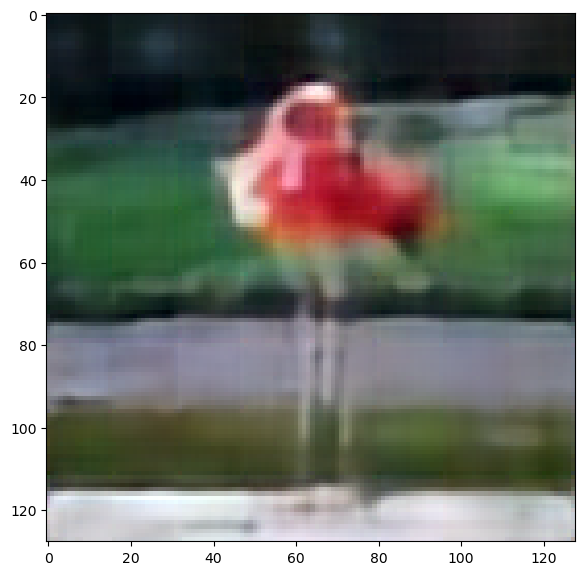

In [29]:
# denoized_img = preds[0]

# # denoized_img = np.clip(denoized_img * 255, 0, 255)
# # denoized_img = denoized_img * 255
                       
# # denoized_img = np.argmax(denoized_img, axis=-1)
# cliped = np.clip(denoized_img, 0, 1)
# img = cv2.cvtColor(cliped, cv2.COLOR_BGR2RGB)
# plt.subplot(121), plt.imshow(img)

# # print(denoized_img)